In [127]:
from synthcity.metrics.eval import Metrics
import pandas as pd
from watermarking.great_watermark import GreatWatermarkLogitProcessor, GreatWatermarkDetector
import transformers

def synthcity_evaluate(real_path,
                       syn_path,
                       result_name=None,
                       real_size = None,
                       syn_size = None):
    real_data = pd.read_csv(real_path)
    syn_data = pd.read_csv(syn_path)
    
    if real_size and real_size < len(real_data):
        real_data = real_data.sample(n=real_size, random_state=42)  # Adjust random_state as desired for reproducibility

    if syn_size and syn_size < len(syn_data):
        syn_data = syn_data.sample(n=syn_size, random_state=42)
    
    metrics = {
        'sanity': ['data_mismatch', 'nearest_syn_neighbor_distance', 'close_values_probability'],
        'stats': ['jensenshannon_dist', 'feature_corr', 'ks_test', 'max_mean_discrepancy', 'prdc', 'alpha_precision'],
        'performance': ['linear_model', 'mlp', 'xgb'],
        # 'detection': ['detection_xgb', 'detection_mlp', 'detection_linear'],
        # 'privacy': ['delta-presence', 'k-anonymization', 'k-map', 'distinct l-diversity', 'identifiability_score']
    }
    
    synthcity_result = Metrics.evaluate(real_data, syn_data, metrics=metrics)
    if result_name:
        synthcity_result.to_csv(result_name)
    return synthcity_result
    
    
def compare(real_file_name, no_water_mark_file_name, with_water_mark_file_name, sample_size=200, round_to=None):
    samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
    real_path = samples_dir + real_file_name
    synth_no_watermark_path = samples_dir + no_water_mark_file_name
    synth_with_watermark_path = samples_dir + with_water_mark_file_name
    
    
    real_df = synthcity_evaluate(real_path, real_path, real_size=sample_size, syn_size=sample_size)[["min"]]
    no_water_mark_df = synthcity_evaluate(real_path, synth_no_watermark_path, real_size=sample_size, syn_size=sample_size)[["min"]]
    with_watermark_df = synthcity_evaluate(real_path, synth_with_watermark_path, real_size=sample_size, syn_size=sample_size)[["min", "direction"]]
    merge_result = real_df.join(no_water_mark_df, lsuffix='_real', rsuffix='_no_watermark')
    merge_result_final = merge_result.join(with_watermark_df)
    
    merge_result_final.columns = ["Real Data", "No-Watermark", "With-Watermark", "Direction"]
    if round_to:
        merge_result_final = merge_result_final.round(round_to)
    return merge_result_final

"""
Utilities
"""

def get_detector(gamma, delta):
    tokenizer = transformers.AutoTokenizer.from_pretrained('distilgpt2', add_prefix_space=True)
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    great_watermark_processor = GreatWatermarkLogitProcessor(tokenizer=tokenizer,
                                                             device="cpu",
                                                             vocab=list(tokenizer.get_vocab().values()),
                                                             gamma=gamma,
                                                             delta=delta)
    great_watermark_detector = GreatWatermarkDetector(great_watermark_processor)
    return great_watermark_detector
    
    
import glob
import re
import os
def get_filenames_from_model(model_name, common_size, gamma, delta, other_schemes=None):
    # Define the search pattern, allowing any string for sample size part
    search_pattern_non_watermark = f"{model_name}_*_non-watermark.csv"
    search_pattern_watermark = f"{model_name}_*_with-watermark_gamma-{gamma}_delta-{delta}.csv"

    # Use glob to get all files matching the search
    directory = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples"
    files_non_watermark = glob.glob(search_pattern_non_watermark, root_dir=directory)
    files_watermark = glob.glob(search_pattern_watermark, root_dir=directory)

    # Regular expressions to extract sample size from filenames
    regex_pattern_non_watermark = re.compile(rf"{model_name}_(\d+)_non-watermark.csv")
    regex_pattern_watermark = re.compile(rf"{model_name}_(\d+)_with-watermark_gamma-{gamma}_delta-{delta}.csv")

    largest_sample_size_non_watermark = -1
    largest_sample_size_with_watermark = -1
    largest_file_non_watermark = None
    largest_file_with_watermark = None
    # Iterate over the matching files and extract sample size
    for file in files_non_watermark:
        match = regex_pattern_non_watermark.match(os.path.basename(file))
        if match:
            sample_size = int(match.group(1))
            if sample_size == common_size:
                largest_file_non_watermark = file
                break
            if sample_size > largest_sample_size_non_watermark:
                largest_sample_size_non_watermark = sample_size
                largest_file_non_watermark = file

    for file in files_watermark:
        match = regex_pattern_watermark.match(os.path.basename(file))
        if match:
            sample_size = int(match.group(1))
            if sample_size == common_size:
                largest_file_with_watermark = file
                break
            if sample_size > largest_sample_size_with_watermark:
                largest_sample_size_with_watermark = sample_size
                largest_file_with_watermark = file
                
    if other_schemes:
        other_schemes_file_names = []
        for scheme_name in other_schemes:
            search_pattern_scheme = f"{model_name}_*_with-watermark_{scheme_name}.csv"
            regex_pattern_scheme = re.compile(rf"{model_name}_(\d+)_with-watermark_{scheme_name}.csv")
            files_scheme = glob.glob(search_pattern_scheme, root_dir=directory)
            largest_sample_size_scheme = -1
            largest_file_sheme = None
            for file in files_scheme:
                match = regex_pattern_scheme.match(os.path.basename(file))
                if match:
                    sample_size = int(match.group(1))
                    if sample_size == common_size:
                        largest_file_sheme = file
                        break
                    if sample_size > largest_sample_size_scheme:
                        largest_sample_size_scheme = sample_size
                        largest_file_sheme = file
            other_schemes_file_names.append(largest_file_sheme)
        return f"{model_name}.csv", largest_file_non_watermark, largest_file_with_watermark, other_schemes_file_names
            
    return f"{model_name}.csv", largest_file_non_watermark, largest_file_with_watermark


"""
Compute one single score for data quality
Compute the average z-score of synthetic data (over a number of samples)
"""


def average_data_quality(real_file_name, no_water_mark_file_name, with_water_mark_file_name, sample_size=1000):
    """
    Compute the average quality of synthetic data, with watermarks and without watermarks
    The scores are divided into 3 groups: resemblance, ML utility and discriminatory 
    Args:
        real_file_name: 
        no_water_mark_file_name: 
        with_water_mark_file_name: 
        size: default to 1000 rows
    """

    scores = compare(
        real_file_name = real_file_name,
        no_water_mark_file_name = no_water_mark_file_name,
        with_water_mark_file_name = with_water_mark_file_name,
        sample_size = sample_size
    )
    
    for col in ['Real Data', 'No-Watermark', 'With-Watermark']:
        scores[col] = scores.apply(lambda row: 1 - row[col] if row['Direction'] == 'minimize' else row[col], axis=1)
    
    scores =  scores.drop('Direction', axis=1)
    scores = scores.astype(float)

    # Resemblance
    resemblance_metrics = ['stats.jensenshannon_dist.marginal',
                           'stats.ks_test.marginal',
                           'stats.max_mean_discrepancy.joint',
               'stats.prdc.precision', 'stats.prdc.recall', 'stats.prdc.density', 'stats.prdc.coverage',
               'stats.alpha_precision.delta_precision_alpha_OC', 'stats.alpha_precision.delta_coverage_beta_OC',
               'stats.alpha_precision.authenticity_OC', 'stats.alpha_precision.delta_precision_alpha_naive',
               'stats.alpha_precision.delta_coverage_beta_naive', 'stats.alpha_precision.authenticity_naive'],
    resemblance_df = scores.loc[resemblance_metrics]  
    resemblance_scores = resemblance_df[['No-Watermark', 'With-Watermark']].mean()
    
    # ML utility metrics
    linear_performance = scores.loc['performance.linear_model.syn_id'] / scores.loc['performance.linear_model.gt']
    mlp_performance = scores.loc['performance.mlp.syn_id'] / scores.loc['performance.mlp.gt']
    xgb_performance = scores.loc['performance.xgb.syn_id'] / scores.loc['performance.xgb.gt']
    ml_performance_scores = (linear_performance + mlp_performance + xgb_performance).drop("Real Data") / 3

    final_scores = {
        "resemblance": resemblance_scores,
        "ml_performance": ml_performance_scores,
        "avg_final_score": (resemblance_scores + ml_performance_scores) / 2
    }
    return final_scores
    
def average_zscore(sample_name, gamma, delta, num_tokens, num_samples = 50, use_weighted_z_score = False):
    """
    Compute the average z_score over a number of random samples from the synthesized data
    """
    samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
    sample_df = pd.read_csv(samples_dir + sample_name)
    
    tokenizer = transformers.AutoTokenizer.from_pretrained('distilgpt2', add_prefix_space=True)
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    great_watermark_processor = GreatWatermarkLogitProcessor(tokenizer=tokenizer,
                                                             device="cpu",
                                                             vocab=list(tokenizer.get_vocab().values()),
                                                             gamma=gamma,
                                                             delta=delta)
    great_watermark_detector = GreatWatermarkDetector(great_watermark_processor)
    
    z_scores = []
    
    for i in range(num_samples):
        if use_weighted_z_score:
            z_scores.append(great_watermark_detector.detect(
            sample_df,
            total_tokens_limit=num_tokens,
            random_state=i,
            # included_columns=["fnlwgt", "occupation"]
            )['weighted_z_score'])
        else:
            z_scores.append(great_watermark_detector.detect(
                sample_df,
                total_tokens_limit=num_tokens,
                random_state=i,
                # included_columns=["fnlwgt", "occupation"]
            )['z_score'])
    return sum(z_scores) / len(z_scores), z_scores

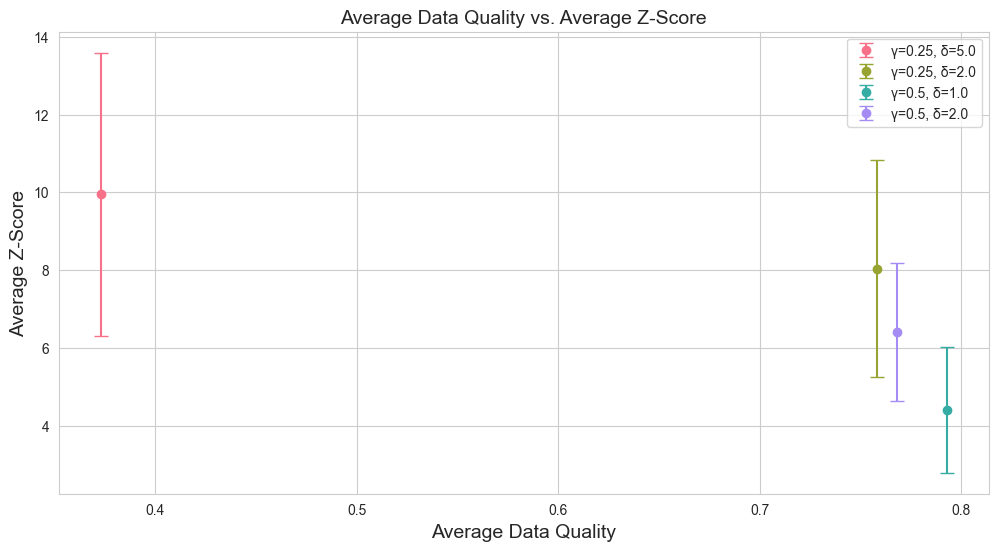

In [107]:
def plot_data_quality_vs_z_score(model_names, gamma_delta_pairs, sample_size, num_tokens, z_threshold=None):
    colors = sns.color_palette('husl', len(gamma_delta_pairs))  # Use a color palette with distinct colors
    data = []
    
    for i, (gamma, delta) in enumerate(gamma_delta_pairs):
        all_z_scores = []
        all_data_quality_scores = []
        for model_index, model_name in enumerate(model_names):
            real_file_name, no_water_mark_file_name, with_water_mark_file_name = get_filenames_from_model(model_name, common_size=1000, gamma=gamma, delta=delta)
    
            data_quality_result = average_data_quality(real_file_name, no_water_mark_file_name, with_water_mark_file_name, sample_size)
    
            all_data_quality_scores.append(data_quality_result["avg_final_score"]["With-Watermark"])
        
            _, z_scores_per_model = average_zscore(with_water_mark_file_name, gamma, delta, num_tokens, use_weighted_z_score=True)
            all_z_scores.append(z_scores_per_model)
        
        avg_z = np.mean(all_z_scores)
        avg_qual = np.mean(all_data_quality_scores)
        
        data.append((avg_qual, avg_z, np.std(all_z_scores), gamma, delta, colors[i]))

    # Convert to DataFrame for easier plotting
    df = pd.DataFrame(data, columns=['Avg Quality', 'Avg Z-Score', 'Z-Score Std', 'Gamma', 'Delta', 'Color'])

    plt.figure(figsize=(12, 6))

    for i, row in df.iterrows():
        plt.errorbar(row['Avg Quality'], row['Avg Z-Score'], yerr=row['Z-Score Std'], fmt='o', color=row['Color'], ecolor=row['Color'], capsize=5, label=f'γ={row["Gamma"]}, δ={row["Delta"]}')

    plt.xlabel('Average Data Quality', fontsize=14)
    plt.ylabel('Average Z-Score', fontsize=14)
    plt.title(f'Average Data Quality vs. Average Z-Score', fontsize=14)
    
    if z_threshold:
        plt.axvline(x=z_threshold, color='red', linestyle='--', label='z-threshold')  # Add vertical red line

    plt.legend()
    plt.grid(True)
    # plt.savefig("avg_z_score_vs_avg_data_quality.pdf")
    plt.show()

# Example usage (assuming you have the required functions and data):
# plot_data_quality_vs_z_score('model_name', [(0.1, 0.01), (0.2, 0.02)], 100, 1000, z_threshold=10)


gamma_delta_pairs = [(0.25, 5.0), (0.25, 2.0), (0.5, 1.0), (0.5, 2.0)]
plot_data_quality_vs_z_score(
    model_names=["adult", "california","diabetes","abalone"],
    gamma_delta_pairs=gamma_delta_pairs,
    sample_size=1000,
    num_tokens=125,
)


In [188]:
"""
Compute ROC and AOC
"""
# import seaborn as sns
import numpy as np
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
from scipy import interpolate


def compute_roc_auc(model_names, gamma_delta_pairs, num_samples_per_class, num_tokens_per_sample, plot_distribution=False, included_columns=None, softmax_temp=2.0, custom_softmax=None):
    tokenizer = transformers.AutoTokenizer.from_pretrained('distilgpt2', add_prefix_space=True)
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    
    results = []
    weighted_results = []
    
    for gamma, delta in gamma_delta_pairs:
        great_watermark_detector = get_detector(gamma, delta)
        real_scores = []
        gen_scores = []
        weighted_real_scores = []
        weighted_gen_scores = []
        for model_name in model_names:
            samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
            real_name, _, syn_name = get_filenames_from_model(model_name, 1000, gamma, delta)
            real_df = pd.read_csv(samples_dir + real_name)
            syn_df = pd.read_csv(samples_dir + syn_name)
            for i in range(int(num_samples_per_class / len(model_names))):
                real_result = great_watermark_detector.detect(real_df, total_tokens_limit=num_tokens_per_sample, random_state=i, included_columns=included_columns, softmax_temperature=softmax_temp, custom_softmax=custom_softmax)
                gen_result = great_watermark_detector.detect(syn_df, total_tokens_limit=num_tokens_per_sample, random_state=i, included_columns=included_columns, softmax_temperature=softmax_temp, custom_softmax=custom_softmax)
                real_scores.append(real_result['z_score'])
                gen_scores.append(gen_result['z_score'])  
                weighted_real_scores.append(real_result['weighted_z_score'])
                weighted_gen_scores.append(gen_result['weighted_z_score'])
        
        # Compute roc auc 
        y_true = np.concatenate([np.zeros(len(real_scores)), np.ones(len(gen_scores))])
        y_scores = np.concatenate([real_scores, gen_scores])
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        results.append((gamma, delta, fpr, tpr, roc_auc))
        
        y_true_weighted = np.concatenate([np.zeros(len(weighted_real_scores)), np.ones(len(weighted_gen_scores))])
        y_scores_weighted = np.concatenate([weighted_real_scores, weighted_gen_scores])
        fpr_weighted, tpr_weighted, thresholds_weighted = roc_curve(y_true_weighted, y_scores_weighted)
        roc_auc_weighted = auc(fpr_weighted, tpr_weighted)
        weighted_results.append((gamma, delta, fpr_weighted, tpr_weighted, roc_auc_weighted))
        
        df = pd.DataFrame({
            'Threshold': thresholds_weighted,
            'FPR': fpr_weighted,
            'TPR': tpr_weighted
        })
        print(df)
        tpr_intrp = interpolate.interp1d(thresholds_weighted, tpr_weighted)
        fpr_intrp= interpolate.interp1d(thresholds_weighted, fpr_weighted)
        
        # print(tpr_intrp(0.122))
        
        # Print the results
        print(f"TPR: {tpr_intrp(2.3)}")
        print(f"FPR: {fpr_intrp(2.3)}")

    
        if plot_distribution:
            plot_z_score_distribution(real_scores, gen_scores, gamma, delta, weighted_real_scores, weighted_gen_scores)
    return {'non_weighted_results': results, "weighted_results": weighted_results}

def plot_roc_curves(results, weighted_results=None):
    if weighted_results:
        fig, axes = plt.subplots(1, 4, figsize=(32, 6))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        axes = [axes]  # Make it iterable

    # Plot the primary ROC curves on the first subplot
    # axes[0].set_title('ROC Curves for Different Gamma and Delta Values')
    lw = 2
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define colors for each line

    for i, (gamma, delta, fpr, tpr, roc_auc) in enumerate(results):
        axes[0].plot(fpr, tpr, lw=lw, label=f'γ={gamma} δ={delta} AUC = {roc_auc:.3f}', c=colors[i % len(colors)])
    
    axes[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate', fontsize=14)
    axes[0].set_ylabel('True Positive Rate', fontsize=14)
    axes[0].legend(loc="lower right", fontsize=12)
    
    for i, (gamma, delta, fpr, tpr, roc_auc) in enumerate(results):
        axes[2].semilogx(fpr, tpr, lw=lw, label=f'γ={gamma} δ={delta} AUC = {roc_auc:.3f}', c=colors[i % len(colors)])
    
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.05])
    axes[2].set_xlabel('False Positive Rate', fontsize=14)
    axes[2].set_ylabel('True Positive Rate', fontsize=14)
    axes[2].legend(loc="lower right", fontsize=12)
    

    # Plot the weighted ROC curves on the second subplot if weighted_results is provided
    if weighted_results:
        # axes[1].set_title('Weighted ROC Curves for Different Gamma and Delta Values')
        for i, (gamma, delta, fpr, tpr, roc_auc) in enumerate(weighted_results):
            axes[1].plot(fpr, tpr, lw=lw, label=f'Weighted γ={gamma} δ={delta} AUC = {roc_auc:.3f}', c=colors[i % len(colors)])
        
        axes[1].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.05])
        axes[1].set_xlabel('False Positive Rate', fontsize=14)
        axes[1].set_ylabel('True Positive Rate', fontsize=14)
        axes[1].legend(loc="lower right", fontsize=12)
        
        for i, (gamma, delta, fpr, tpr, roc_auc) in enumerate(weighted_results):
            axes[3].semilogx(fpr, tpr, lw=lw, label=f'Weighted γ={gamma} δ={delta} AUC = {roc_auc:.3f}', c=colors[i % len(colors)])
        
        axes[3].set_xlim([0.0, 1.0])
        axes[3].set_ylim([0.0, 1.05])
        axes[3].set_xlabel('False Positive Rate', fontsize=14)
        axes[3].set_ylabel('True Positive Rate', fontsize=14)
        axes[3].legend(loc="lower right", fontsize=12)

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    # plt.savefig("roc_curves_include_semilog.pdf")
    plt.show()

def plot_roc_curves_separated_figures(results, weighted_results):
    lw = 2
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define colors for each line

    for i, (gamma, delta, fpr, tpr, roc_auc) in enumerate(results):
        plt.plot(fpr, tpr, lw=lw, label=f'γ={gamma} δ={delta} AUC = {roc_auc:.3f}', c=colors[i % len(colors)])
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    # plt.savefig("roc_all_datasets_non_weighted.pdf")
    plt.show()
    
    for i, (gamma, delta, fpr, tpr, roc_auc) in enumerate(results):
        plt.semilogx(fpr, tpr, lw=lw, label=f'γ={gamma} δ={delta} AUC = {roc_auc:.3f}', c=colors[i % len(colors)])
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    # plt.savefig("roc_all_datasets_non_weighted_semilog.pdf")
    plt.show()
    
    for i, (gamma, delta, fpr, tpr, roc_auc) in enumerate(weighted_results):
        plt.plot(fpr, tpr, lw=lw, label=f'γ={gamma} δ={delta} AUC = {roc_auc:.3f}', c=colors[i % len(colors)])
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    # plt.savefig("roc_all_datasets_weighted.pdf")
    plt.show()
    
    for i, (gamma, delta, fpr, tpr, roc_auc) in enumerate(weighted_results):
        plt.semilogx(fpr, tpr, lw=lw, label=f'γ={gamma} δ={delta} AUC = {roc_auc:.3f}', c=colors[i % len(colors)])
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc="lower right", fontsize=12)
    # plt.savefig("roc_all_datasets_weighted_semilog.pdf")
    plt.show()

def plot_z_score_distribution(real_scores, gen_scores, gamma, delta, weighted_real_scores=None, weighted_gen_scores=None):
    # fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the first set of kernel density plots on the first subplot
    sns.kdeplot(real_scores, label='Real', shade=True)
    sns.kdeplot(gen_scores, label='Synthetic', shade=True)
    if weighted_real_scores and weighted_gen_scores:
        sns.kdeplot(weighted_real_scores, label='Weighted Real', shade=True)
        sns.kdeplot(weighted_gen_scores, label='Weighted Synthetic', shade=True)
    
    plt.xlim(-15, 15)
    plt.ylim(0, 0.5)
    plt.xlabel('z-scores', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'z-scores distribution γ={gamma} δ={delta}', fontsize=14)
    plt.legend(loc="upper left")
    # plt.savefig(f"z_score_distribution_diabetes_γ={gamma}_δ={delta}.pdf")

    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the plot
    plt.show()

    Threshold  FPR       TPR
0         inf  0.0  0.000000
1   39.654116  0.0  0.004032
2   17.274285  0.0  0.766129
3   17.243551  0.0  0.774194
4   17.173588  0.0  0.790323
5   17.172023  0.0  0.798387
6   17.125461  0.0  0.818548
7   17.103624  0.0  0.826613
8   17.031083  0.0  0.858871
9   17.030531  0.0  0.866935
10  16.955537  0.0  0.899194
11  16.953973  0.0  0.907258
12  16.905493  0.0  0.919355
13  16.889039  0.0  0.927419
14  16.820640  0.0  0.955645
15  16.814045  0.0  0.963710
16  16.612893  0.0  1.000000
17  -3.694248  1.0  1.000000
TPR: 1.0
FPR: 0.7048206868276887


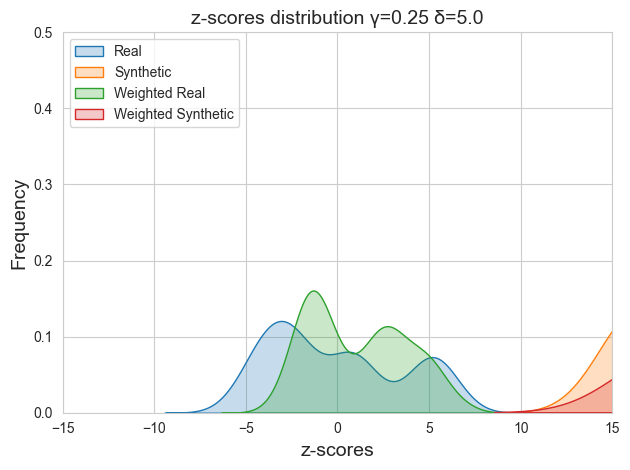

   Threshold  FPR       TPR
0        inf  0.0  0.000000
1  32.049129  0.0  0.004032
2  12.680728  0.0  1.000000
3  -3.694248  1.0  1.000000
TPR: 1.0
FPR: 0.6339385076380966


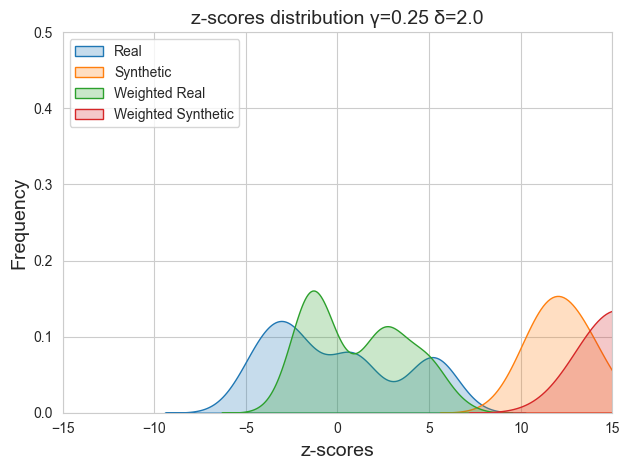

   Threshold  FPR       TPR
0        inf  0.0  0.000000
1  12.191764  0.0  0.004032
2   5.976291  0.0  1.000000
3  -4.695478  1.0  1.000000
TPR: 1.0
FPR: 0.3444874816264466


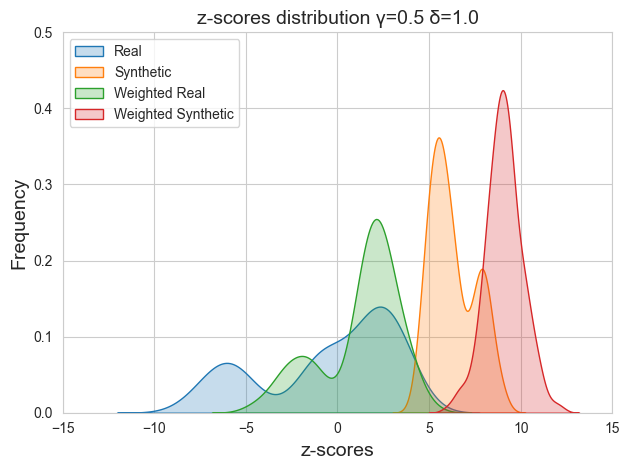

   Threshold  FPR       TPR
0        inf  0.0  0.000000
1  19.235603  0.0  0.004032
2   7.493791  0.0  1.000000
3  -4.695478  1.0  1.000000
TPR: 1.0
FPR: 0.42609536484034394


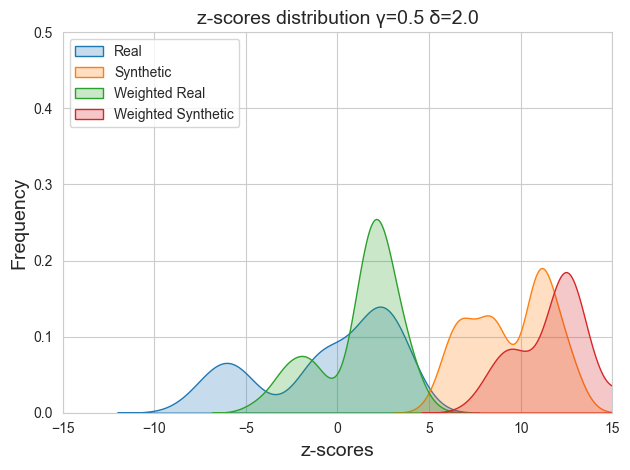

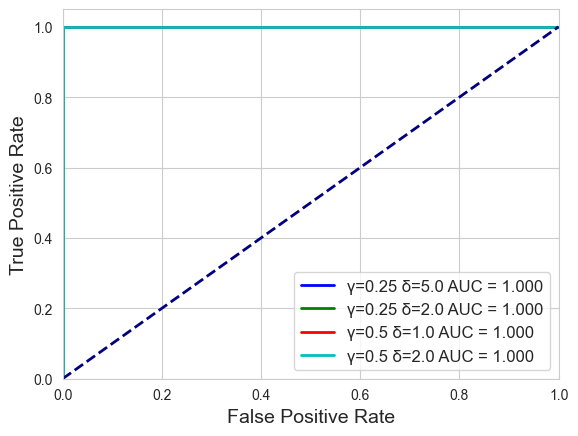

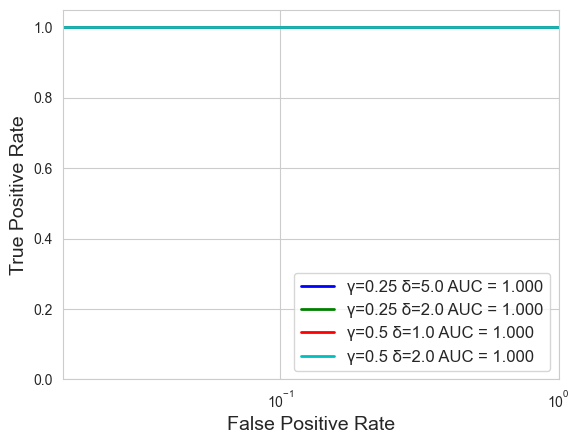

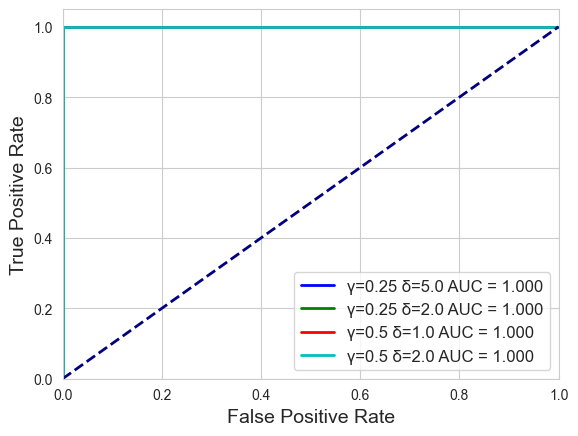

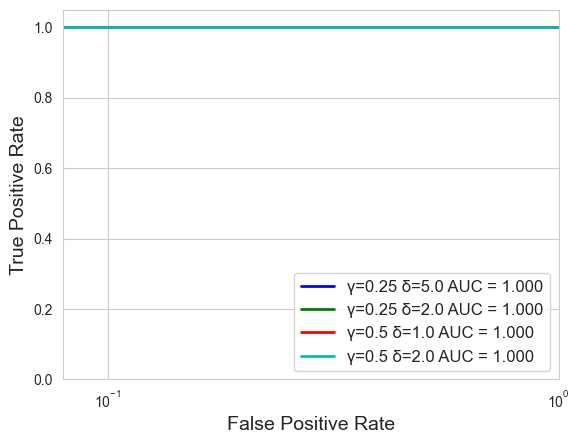

In [189]:
gamma_delta_pairs = [(0.25, 5.0), (0.25, 2.0), (0.5, 1.0), (0.5, 2.0)]
results = compute_roc_auc(
    ["adult", "california", "abalone", "diabetes"],
    gamma_delta_pairs=gamma_delta_pairs,
    num_samples_per_class=250,
    num_tokens_per_sample=1000,
    plot_distribution=True,
    softmax_temp=5.0,
    custom_softmax=lambda x : softmax(x * 1.5 / np.max(x), 1.0)
)
# Plot all ROC curves
plot_roc_curves_separated_figures(results["non_weighted_results"], results["weighted_results"])

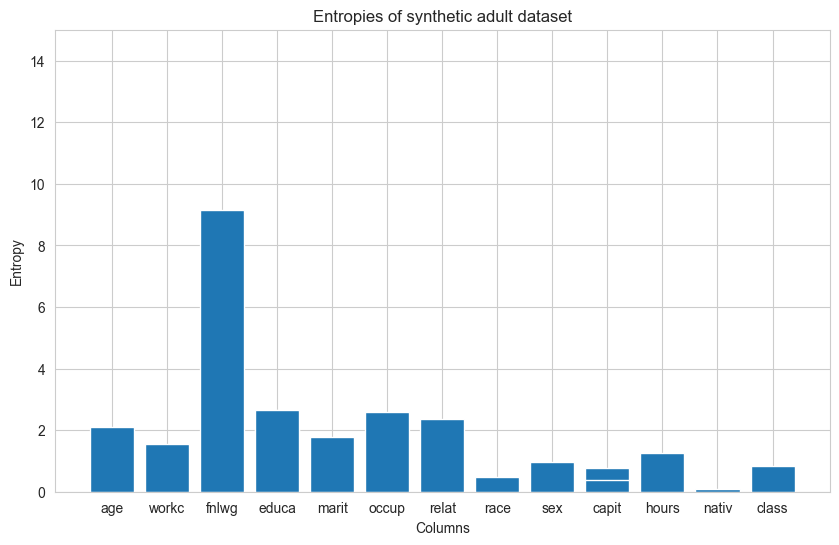

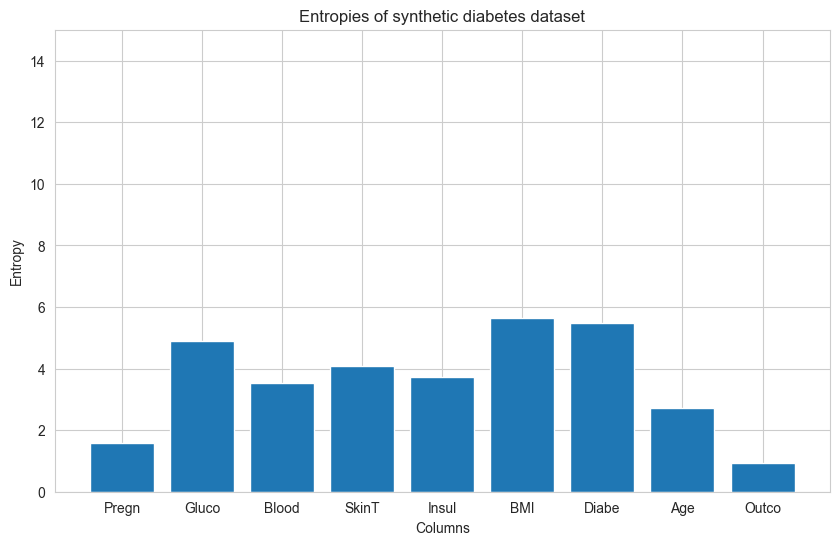

In [39]:
"""
Calculate entropy for each column in a df
"""
def table_entropy(df):
    entropies = {}
    for col_name in df.columns:
        if pd.api.types.is_numeric_dtype(df[col_name]):
            converted_col = pd.to_numeric(df[col_name], errors='coerce')
        else:
            converted_col = df[col_name].astype('category')
        
        value_counts = converted_col.value_counts()
    
        # Calculate probability for each value
        probabilities = value_counts / len(converted_col)
        
        # Calculate entropy
        entropies[col_name] = -np.sum(probabilities * np.log2(probabilities))
    
    return entropies

def plot_entropies(df, plot_name = None):
    entropies = table_entropy(df)

    shortened_labels = [col[:5] for col in entropies.keys()]
    
    plt.figure(figsize=(10, 6))
    plt.bar(shortened_labels, entropies.values())
    plt.xlabel('Columns')
    plt.ylabel('Entropy')
    plt.ylim(0, 15)
    plt.title(plot_name if plot_name else 'Entropy of each column in the dataset')
    # plt.savefig(f"{plot_name}.pdf")
    plt.show()
    
def plot_alo(alo, plot_name = None):
    entropies = alo

    shortened_labels = [col[:5] for col in entropies.keys()]
    
    plt.figure(figsize=(10, 6))
    plt.bar(shortened_labels, entropies.values())
    plt.xlabel('Columns')
    plt.ylabel('Scaled Weights')
    plt.title(f'Scaled weights of {plot_name} dataset')
    plt.show()
    
def plot_entropies_by_model_name(model_name, gamma, delta, common_size):
    real, no_wa, with_wa = get_filenames_from_model(model_name, common_size, gamma, delta)
    
    samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
    real_path = samples_dir + real
    # synth_no_watermark_path = samples_dir + no_wa
    synth_with_watermark_path = samples_dir + with_wa
    # 
    # plot_entropies(pd.read_csv(real_path), plot_name=f"Entropy of real {model_name} dataset")
    
    plot_entropies(pd.read_csv(synth_with_watermark_path), plot_name=f"Entropies of synthetic {model_name} dataset")
    
    # plot_entropies(pd.read_csv(real_path), plot_name=f"Entropies of real {model_name} dataset")
    
plot_entropies_by_model_name("adult", 0.25, 2.0, 1000)

plot_entropies_by_model_name("diabetes", 0.25, 2.0, 1000)

In [6]:

def power(x, n):
    power_x = np.power(x, n)
    return power_x / power_x.sum(axis=0)

def softmax(x, T=1.0):
    e_x = np.exp((x - np.max(x)) / T)  # Subtract max for
    return e_x / e_x.sum(axis=0)

def custom_exp(x, base, T=1.0):
    e_x = np.power(base, (x - np.max(x)) / T)
    return e_x / e_x.sum(axis=0)

df = pd.read_csv("/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/adult.csv")

entropies = table_entropy(df)
values = list(entropies.values())
x = np.array(values)

l = len(df.columns)
weights = pd.DataFrame({
    'Column Name': list(entropies.keys()),
    'Entropy Value': values,
    # "soft `1.0": softmax(x, 1.0) * l,
    "Weights (T = 1.5)": softmax(x * 1.5/ np.max(x), 1.0) * l,
    "Weights (T = 2.0)": softmax(x * 2.0/ np.max(x), 1.0) * l,
    "soft 3.0": softmax(x, 3.0) * l,
    "soft 5.0": softmax(x, 5.0) * l,
    # "soft 7.5": softmax(x, 7.5) * l,
    # "soft 10.0": softmax(x, 10.0) * l,
    "exp 1.25": custom_exp(x, 1.25, 2.0) * l,
    "exp 1.5": custom_exp(x, 1.5, T = 2.0) * l , # seems good ~ soft T = 5.0
    "exp 2.0": custom_exp(x, 2.0) * l,
    "exp 2.7": custom_exp(x, 2.7) * l
    # "soft 7.5": softmax(x, 7.5) * l,
    # "softm 10.0": softmax_mean(x, 10.0) * l,
})

cols = weights.columns.to_list()
cols.remove("Column Name")
for col in cols:
    weights[col] = weights[col].round(3)
# Display the DataFrame
weights

,Column Name,Entropy Value,Weights (T = 1.5),Weights (T = 2.0),soft 3.0,soft 5.0,exp 1.25,exp 1.5,exp 2.0,exp 2.7
0,age,2.278,0.898,0.819,0.213,0.625,0.882,0.615,0.003,0.000
1,workclass,1.422,0.822,0.728,0.160,0.526,0.802,0.517,0.002,0.000
2,fnlwgt,14.481,3.180,4.419,12.467,7.173,3.443,7.303,14.965,14.999
3,education,2.931,0.961,0.896,0.265,0.712,0.949,0.702,0.005,0.000
4,education-num,2.931,0.961,0.896,0.265,0.712,0.949,0.702,0.005,0.000
5,marital-status,1.836,0.858,0.771,0.184,0.572,0.840,0.562,0.002,0.000
6,occupation,3.286,0.997,0.942,0.299,0.764,0.987,0.755,0.006,0.000
7,relationship,2.155,0.887,0.805,0.205,0.610,0.870,0.600,0.003,0.000
8,race,0.795,0.770,0.668,0.130,0.464,0.748,0.456,0.001,0.000
9,sex,0.916,0.780,0.679,0.136,0.476,0.758,0.467,0.001,0.000


In [22]:
def plot_single_metric_between_model(model_names, metric_name, gamma, delta, sample_size=1000):

    non_watermark_scores = []
    with_watermark_scores = []
    for model_name in model_names:
        real_file_name, no_water_mark_file_name , with_water_mark_file_name = get_filenames_from_model(model_name, common_size=1000, gamma=0.25, delta=2.0)
        
        
        
        average_data_quality_result = average_data_quality(real_file_name, no_water_mark_file_name, with_water_mark_file_name, sample_size)
        
        non_watermark_scores.append(average_data_quality_result[metric_name]["No-Watermark"])
        
        with_watermark_scores.append(average_data_quality_result[metric_name]["With-Watermark"])
    
    scores = {
        "Non-Watermark": non_watermark_scores,
        "With-Watermark": with_watermark_scores
    }
            

    x = np.arange(len(model_names))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0    
    
    fig, ax = plt.subplots(layout='constrained')
    
    for attribute, measurement in scores.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(metric_name)
    ax.set_xlabel("Datasets")
    ax.set_title(f"{metric_name} scores of samples with and without watermark")
    ax.set_xticks(x + width, model_names)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 1.1)
    # plt.savefig(f"{metric_name}_between_datasets.png")
    plt.show()

def plot_single_metric_between_model_with_other_schemes(model_names, metric_name, gamma, delta, sample_size=1000, other_schemes = ['exp']):

    non_watermark_scores = []
    with_watermark_scores = []
    exp_scores = []
    
    for model_name in model_names:
        real_file_name, no_water_mark_file_name , with_water_mark_file_name, other_schemes_names = get_filenames_from_model(model_name, common_size=1000, gamma=0.25, delta=2.0, other_schemes=other_schemes)
        
        average_data_quality_result = average_data_quality(real_file_name, no_water_mark_file_name, with_water_mark_file_name, sample_size)
        
        average_data_quality_exp = average_data_quality(real_file_name, no_water_mark_file_name, other_schemes_names[0], sample_size)
        
        non_watermark_scores.append(average_data_quality_result[metric_name]["No-Watermark"])
        
        with_watermark_scores.append(average_data_quality_result[metric_name]["With-Watermark"])
        
        exp_scores.append(average_data_quality_exp[metric_name]["With-Watermark"])
    
    scores = {
        "Non-Watermark": non_watermark_scores,
        "KGW": with_watermark_scores,
        "EXP": exp_scores
    }
            

    x = np.arange(len(model_names))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0    
    
    fig, ax = plt.subplots(layout='constrained')
    
    for attribute, measurement in scores.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(metric_name)
    ax.set_xlabel("Datasets")
    ax.set_title(f"{metric_name} scores of samples with and without watermark")
    ax.set_xticks(x + width, model_names)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 1.1)
    # plt.savefig(f"{metric_name}_between_datasets.png")
    plt.show()


# plot_single_metric_between_model(model_names = ["california", "abalone", "adult", "diabetes"],
#                                  metric_name="resemblance",
#                                  gamma=0.25,
#                                  delta=2.0,
#                                  sample_size=1000)

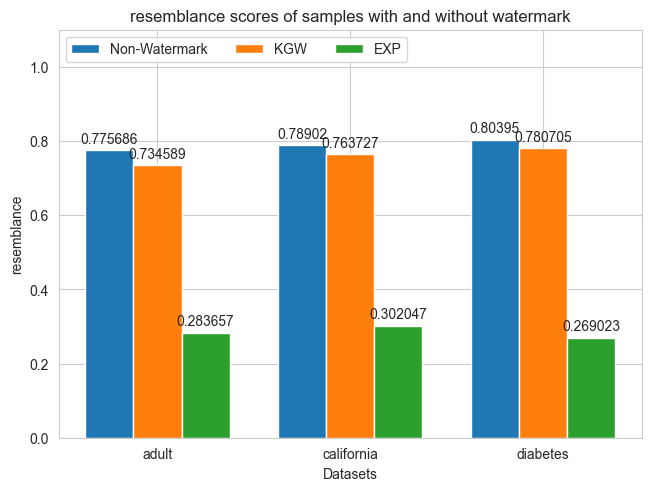

In [23]:
plot_single_metric_between_model_with_other_schemes(model_names = ["adult", "california", "diabetes"],
                                 metric_name="resemblance",
                                 gamma=0.25,
                                 delta=2.0,
                                 sample_size=1000,
                                other_schemes=['exp'])

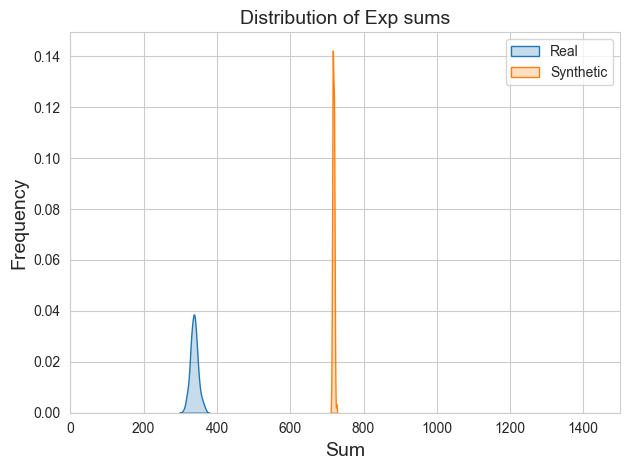

[(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
  array([0.   , 0.008, 0.032, 0.104, 0.16 , 0.384, 0.6  , 0.864, 0.976,
         1.   , 1.   ]),
  1.0)]

In [121]:
"""
Compute ROC and AOC
"""
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from watermarking.exp_watermark import GreatEXPWatermarkDetector, GreatEXPWatermarkLogitProcessor



def compute_roc_auc_exp(model_names, num_samples_per_class, num_tokens_per_sample, plot_distribution=False, included_columns=None):
    tokenizer = transformers.AutoTokenizer.from_pretrained('distilgpt2', add_prefix_space=True)
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    
    great_exp_watermark_processor = GreatEXPWatermarkLogitProcessor(tokenizer=tokenizer,
                                                                    device="cpu",
                                                                    vocab=list(tokenizer.get_vocab().values()))
    great_exp_watermark_detector = GreatEXPWatermarkDetector(great_exp_watermark_processor)
        
    real_scores = []
    gen_scores = []
    
    results = []

    for model_name in model_names:
        samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
        
        real_name, _, _, exp_names = get_filenames_from_model(model_name, 1000, 0.25, 2.0, other_schemes=['exp'])
        exp_name = exp_names[0]
        
        real_df = pd.read_csv(samples_dir + real_name)
        syn_df = pd.read_csv(samples_dir + exp_name)
        
        for i in range(int(num_samples_per_class / len(model_names))):
            real_result = great_exp_watermark_detector.detect(real_df, total_tokens_limit=num_tokens_per_sample, random_state=i, included_columns=included_columns)
            
            gen_result = great_exp_watermark_detector.detect(syn_df, total_tokens_limit=num_tokens_per_sample, random_state=i, included_columns=included_columns)
            
            real_scores.append(real_result['final_sum'])
            gen_scores.append(gen_result['final_sum'])  
        
        # Compute roc auc 
    y_true = np.concatenate([np.zeros(len(real_scores)), np.ones(len(gen_scores))])
    y_scores = np.concatenate([real_scores, gen_scores])
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    results.append((fpr, tpr, roc_auc))
        
    if plot_distribution:
        plot_exp_sum_distribution(real_scores, gen_scores)
    return results

def plot_roc_curves_exp(results):

    fig, axes = plt.subplots(1, 1, figsize=(8, 6))
    axes = [axes]  # Make it iterable

    # Plot the primary ROC curves on the first subplot
    axes[0].set_title('ROC Curves')
    lw = 2
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define colors for each line

    for i, (fpr, tpr, roc_auc) in enumerate(results):
        axes[0].plot(fpr, tpr, lw=lw, label=f'area = {roc_auc:.3f}', c=colors[i % len(colors)])
    
    axes[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate', fontsize=14)
    axes[0].set_ylabel('True Positive Rate', fontsize=14)
    axes[0].legend(loc="lower right", fontsize=12)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the plot
    plt.show()


def plot_exp_sum_distribution(real_scores, gen_scores):
# Plot the first set of kernel density plots on the first subplot
    sns.kdeplot(real_scores, label='Real', shade=True)
    sns.kdeplot(gen_scores, label='Synthetic', shade=True)
    
    plt.xlim(0, 1500)

    plt.xlabel('Sum', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'Distribution of Exp sums', fontsize=14)
    plt.legend()
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Show the plot
    plt.show()

compute_roc_auc_exp(
    ["diabetes"],
    num_samples_per_class=125, 
    num_tokens_per_sample=250,
    plot_distribution=True,
)


In [204]:
def plot_post_editing_attack(model_names, gamma_delta_pairs, num_samples_per_class, num_tokens_per_sample, attack_type, custom_softmax, z_threshold=None):
    tokenizer = transformers.AutoTokenizer.from_pretrained('distilgpt2', add_prefix_space=True)
    tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.pad_token = tokenizer.eos_token
    
    final_results = []
    
    for gamma, delta in gamma_delta_pairs:
        great_watermark_detector = get_detector(gamma, delta)
        
        real_scores = []
        weighted_real_scores = []
        synth_non_weighted_non_attacked = []
        synth_weighted_non_attacked = []
        synth_non_weighted_attacked = []
        synth_weighted_attacked = []

        for model_name in model_names:
            samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
            
            attacked_samples_dir = samples_dir + "attacked_samples/"
            
            real_name, _, syn_name = get_filenames_from_model(model_name, 1000, gamma, delta)
            real_df = pd.read_csv(samples_dir + real_name)
            syn_df = pd.read_csv(samples_dir + syn_name)
            syn_attacked_df = pd.read_csv(attacked_samples_dir + attack_type + '_'+ syn_name)
            
            for i in range(int(num_samples_per_class / len(model_names))):
                real_result = great_watermark_detector.detect(real_df, total_tokens_limit=num_tokens_per_sample, random_state=i, custom_softmax=custom_softmax)
                gen_result = great_watermark_detector.detect(syn_df, total_tokens_limit=num_tokens_per_sample, random_state=i, custom_softmax=custom_softmax)
                gen_attacked_result = great_watermark_detector.detect(syn_attacked_df, total_tokens_limit=num_tokens_per_sample, random_state=i, custom_softmax=custom_softmax)
                                
                real_scores.append(real_result['z_score'])
                weighted_real_scores.append(real_result['weighted_z_score'])
                
                synth_non_weighted_non_attacked.append(gen_result['z_score'])
                synth_weighted_non_attacked.append(gen_result['weighted_z_score'])
                
                synth_non_weighted_attacked.append(gen_attacked_result['z_score'])
                synth_weighted_attacked.append(gen_attacked_result['weighted_z_score'])
                
        y_true = np.concatenate([np.zeros(len(real_scores)), np.ones(len(synth_non_weighted_attacked))])
        y_scores = np.concatenate([real_scores, synth_non_weighted_attacked])
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        
        y_true_weighted = np.concatenate([np.zeros(len(weighted_real_scores)), np.ones(len(synth_weighted_attacked))])
        y_scores_weighted = np.concatenate([weighted_real_scores, synth_weighted_attacked])
        fpr_weighted, tpr_weighted, thresholds_weighted = roc_curve(y_true_weighted, y_scores_weighted)
        roc_auc_weighted = auc(fpr_weighted, tpr_weighted)
        
        tpr_intrp = interpolate.interp1d(thresholds, tpr)
        tpr_intrp_weighted = interpolate.interp1d(thresholds_weighted, tpr_weighted)
        
        final_results.append({
            'gamma': gamma,
            'delta': delta,
            'auc_non_weighted': roc_auc,
            'tpr_non_weighted': tpr_intrp(z_threshold),
            'auc_weighted': roc_auc_weighted,
            'tpr_weighted': tpr_intrp_weighted(z_threshold),
        })
                
        data = {
            'Negative': real_scores,
            
            'KGW Non-Attacked': synth_non_weighted_non_attacked,
            'KGW Attacked': synth_non_weighted_attacked,
            
            'Weighted KGW Non-Attacked': synth_weighted_non_attacked,
            'Weighted KGW Attacked': synth_weighted_attacked
        }
            
        custom_palette = {
            'Negative': 'skyblue',                           # Unique color for Negative
            'KGW Non-Attacked': 'lightgreen',                # Same color for KGW Non-Attacked
            'KGW Attacked': 'lightcoral',                    # Same color for KGW Attacked
            'Weighted KGW Non-Attacked': 'lightgreen',       # Same color for Weighted KGW Non-Attacked
            'Weighted KGW Attacked': 'lightcoral'            # Same color for Weighted KGW Attacked
        }
            
        # Convert the dictionary into a DataFrame for easier manipulation with seaborn
        temp_df = pd.DataFrame(data)
        
        # Melt the DataFrame to format it for seaborn
        df_melted = temp_df.melt(var_name='Category', value_name='Values')
        
        # Create the violin plot
        plt.figure(figsize=(10, 6))
        sns.violinplot(x='Category', y='Values', data=df_melted, palette=custom_palette)
        if z_threshold:
            plt.axhline(y=z_threshold, color='red', linestyle='--')
        plt.title(f'Distribution of z-scores KGW vs Weighted KGW under {attack_type} attack')
        plt.xlabel('KGW vs Weighted-KGW')
        plt.ylabel('z-scores')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # plt.savefig(f"{attack_type} attack.pdf")
        plt.show()
        
    return final_results

def modify_df_paraphrase(syn_df=None, syn_name=None, write_to_file=False):
    samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
    paraphrase_mapping = {
        'marital-status': {
            'Married-civ-spouse': 'Legally married',
            'Never-married': 'Single',
            'Divorced': 'Legally separated',
            'Widowed': 'Lost spouse',
            'Separated': 'Living apart',
            'Married-spouse-absent': 'Married but apart'
        },
        'sex': {
            'Female':'F',
            'Male':'M'
        },
        'native-country': {
            'United-States': 'USA'
        },
        'occupation': {
            'Protective-serv': 'Protective Services',
            'Sales': 'Sales',
            'Craft-repair': 'Craft & Repair',
            'Adm-clerical': 'Admin Clerical',
            'Other-service': 'Other Services',
            'Prof-specialty': 'Professional Specialty',
            'Tech-support': 'Tech Support',
            'Exec-managerial': 'Exec Management',
            'Transport-moving': 'Transport & Moving',
            'Machine-op-inspct': 'Machine Op Inspection',
            'Farming-fishing': 'Farming & Fishing'
        }
    }
    
    if syn_name:
        syn_df = pd.read_csv(samples_dir + syn_name)

    for col in syn_df.columns:
        if col in paraphrase_mapping:
            syn_df[col] = syn_df[col].replace(paraphrase_mapping[col])
    
    if write_to_file:
        syn_df.to_csv(f'{samples_dir}/attacked_samples/synonym_{syn_name}', index=False)
        
    return syn_df

def modify_df_rounding(digits, syn_df=None, syn_name=None, write_to_file=False):
    samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
    """Round numerical columns in a DataFrame to a specified number of digits."""
    
    if syn_name:
        syn_df = pd.read_csv(samples_dir + syn_name)
    
    numerical_cols = syn_df.select_dtypes(include=[np.number]).columns
    syn_df[numerical_cols] = syn_df[numerical_cols].round(digits)
    
    if write_to_file:
        syn_df.to_csv(f'{samples_dir}/attacked_samples/rounding_{digits}_digits_{syn_name}', index=False)
    return syn_df
    
def modify_df_random_shift_scale(syn_df=None, syn_name=None, shift_percent=0.05, write_to_file=False, seed=42):
    """Apply random shift and scaling to numerical columns in a DataFrame."""
    samples_dir = "/Users/minhkau/Documents/TUDelft/Year 3/RP/Code/tabular-gpt/samples/"
    """Round numerical columns in a DataFrame to a specified number of digits."""
    
    if syn_name:
        syn_df = pd.read_csv(samples_dir + syn_name)
    
    np.random.seed(seed)
    
    numerical_cols = syn_df.select_dtypes(include=[np.number]).columns
        
    for col in numerical_cols:
        
        original_decimal_places = syn_df[col].astype(str).apply(lambda v : len(v.split('.')[1]))
        
        shift_factor = np.random.uniform(1 - shift_percent, 1 + shift_percent, size=syn_df[col].shape)
        syn_df[col] = syn_df[col] * shift_factor
        
        # Round each element in the column to its original number of decimal places
        syn_df[col] = syn_df.apply(lambda row: round(row[col], original_decimal_places[row.name]), axis=1)
    
    
    if write_to_file:
        syn_df.to_csv(f'{samples_dir}/attacked_samples/shift_{shift_percent}_{syn_name}', index=False)
        
    return syn_df

In [191]:
for model_name in ["abalone","california","adult","diabetes"]:
    gamma = 0.25
    delta = 2.0
    _, _, syn_name = get_filenames_from_model(model_name, 1000, gamma, delta)
    
    # modify_df_random_shift_scale(syn_name=syn_name, shift_percent=.05, write_to_file=True)
    # modify_df_random_shift_scale(syn_name=syn_name, shift_percent=.1, write_to_file=True)
    # modify_df_random_shift_scale(syn_name=syn_name, shift_percent=.25, write_to_file=True)

    # modify_df_rounding(digits=2, syn_name=syn_name, write_to_file=True)
    # modify_df_rounding(digits=0, syn_name=syn_name, write_to_file=True) 


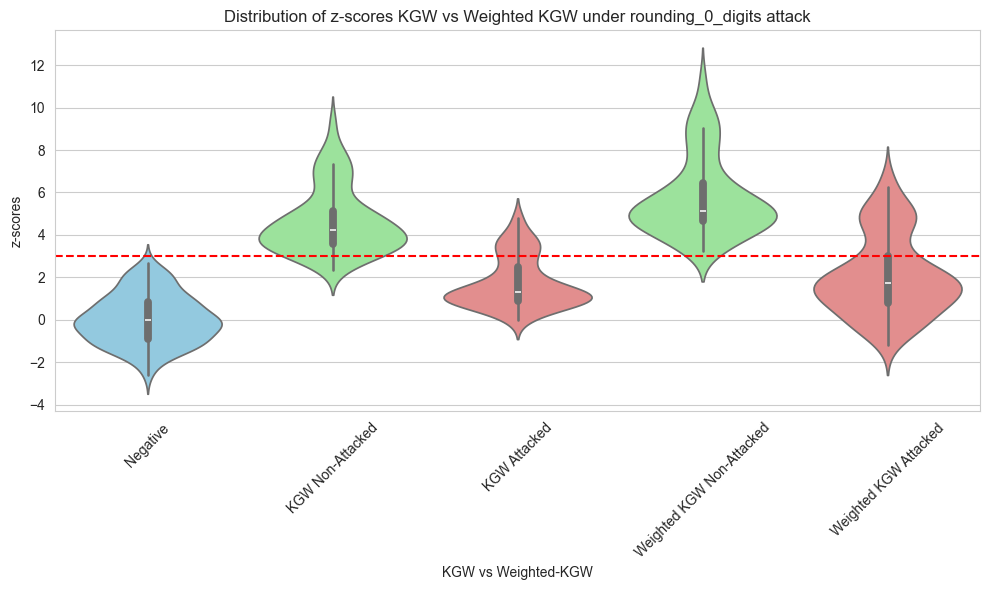

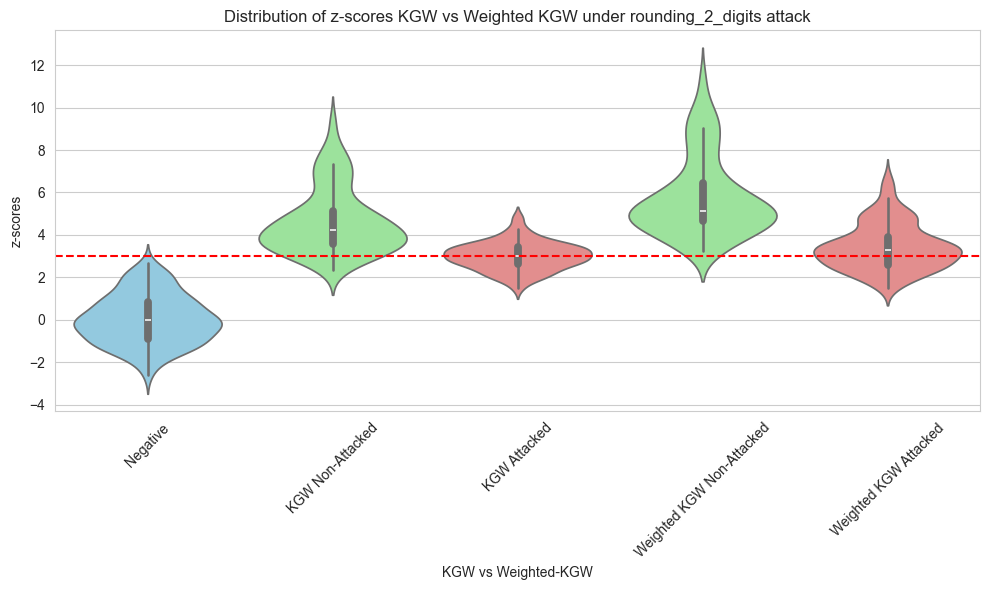

In [208]:
all_results = []
# for attack_type in ["shift_0.1", "shift_0.25","shift_0.05"]:
for attack_type in ["rounding_0_digits", "rounding_2_digits"]:
    result = plot_post_editing_attack(["abalone","california","adult","diabetes"],
                         [(0.25, 2.0)],
                         num_samples_per_class = 125,
                         num_tokens_per_sample= 125,
                         attack_type=attack_type,
                         custom_softmax=(lambda x : softmax(x * 1.5 / np.max(x), 1.0)),
                         z_threshold=3.0)
    all_results.append(result[0])

results_df = pd.DataFrame(all_results)
results_df.to_csv("ahh_roundings.csv")

    

In [209]:
df1 = pd.read_csv("ahhhhhh.csv")
df2 = pd.read_csv("ahh_roundings.csv")
combined = df1.append(df2)
combined.to_csv("ajdfadjbfad.csv")